## Visualización de los datos ModelNet10

### Librerias usadas

In [1]:
import sys
sys.path.insert(0, '/Users/ahmedbegga/Desktop/TFG-Ahmed/SetXAI')
from torch.utils.data import DataLoader, Dataset, TensorDataset
from data .Modelnet10toSet import *
import matplotlib.pyplot as plt
import random

### Carga del dataset

In [4]:
dataset = PointCloudData()
class_names =   [ 'bathtub' , 'bed' , 'chair',  'desk' , 'dresser' , 'monitor' , 'night_stand' , 'sofa' ,  'table' ,  'toilet']
sampleSet = []
for i in range(0,len(class_names)):
    for j in range(0,len(dataset)):
        if i == dataset[j]['category']:
            sampleSet.append(dataset[j]['pointcloud'])
            break

### Información del dataset

Tamaño del dataset:  3991
Numero de elementos por muestra:  3 que se corresponde con la etiqueta, el conjunto de puntos y la mascara
Tamaño del conjunto de puntos:  (3, 2048)
Representación del conjunto de puntos: 


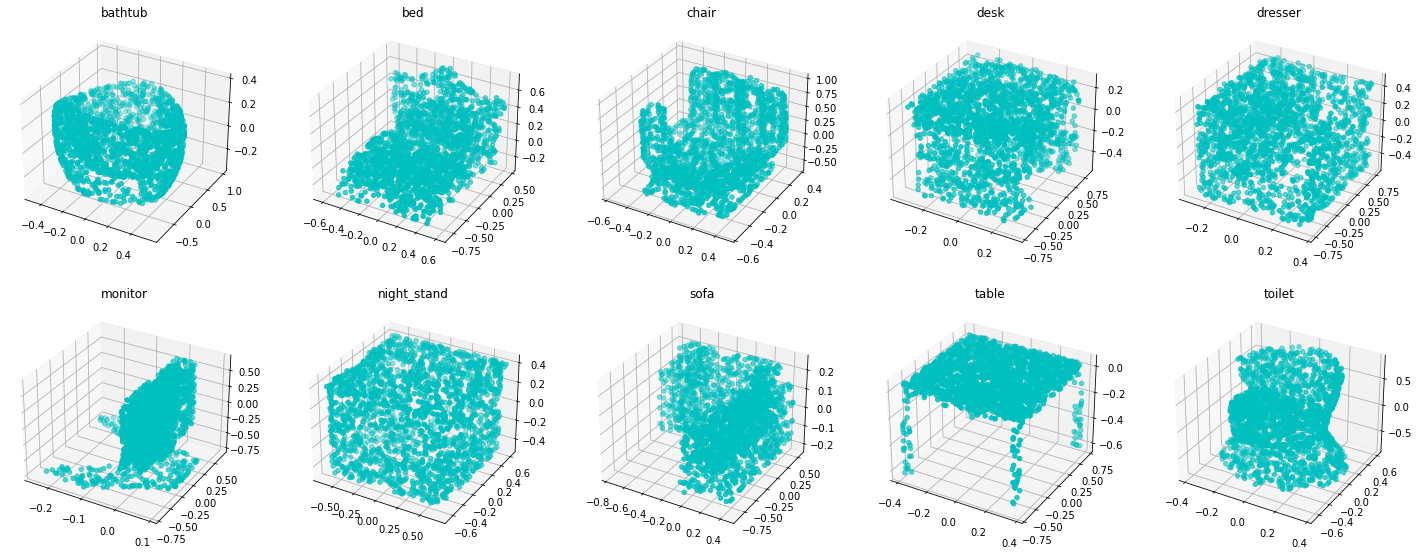

In [8]:
print('Tamaño del dataset: ',len(dataset))
print('Numero de elementos por muestra: ',len(dataset[0]),'que se corresponde con la etiqueta, el conjunto de puntos y la mascara')
print('Tamaño del conjunto de puntos: ',dataset[0]['pointcloud'].numpy().shape)
print('Representación del conjunto de puntos: ')
fig = plt.figure(figsize=(25, 25))
for i in range(10):
    ax = fig.add_subplot(5,5,i+1, projection='3d')
    s = sampleSet[i]
    # plot a 3D surface like in the example mplot3d/surface3d_demo
    surf = ax.scatter(s[0,:].numpy(), s[1,:].numpy(), s[2, :].numpy(),color='c',marker='o',s=20)
    plt.title(class_names[i])
    # ==============

In [9]:
a = sampleSet[8].numpy()
sampleSet[8].numpy().shape

(3, 2048)

In [10]:
pcshow(a[0],a[1],a[2])

### Cargar el dataset en un dataloader de pytorch

In [10]:
data_loader = DataLoader(dataset, batch_size=32,shuffle=True)
data_loader

In [11]:
data_iter = iter(data_loader)
data = data_iter.next()
print(data['pointcloud'].shape)
print(data['category'].shape)
print(data['mask'].shape)

torch.Size([32, 3, 2048])
torch.Size([32])
torch.Size([32, 2048])


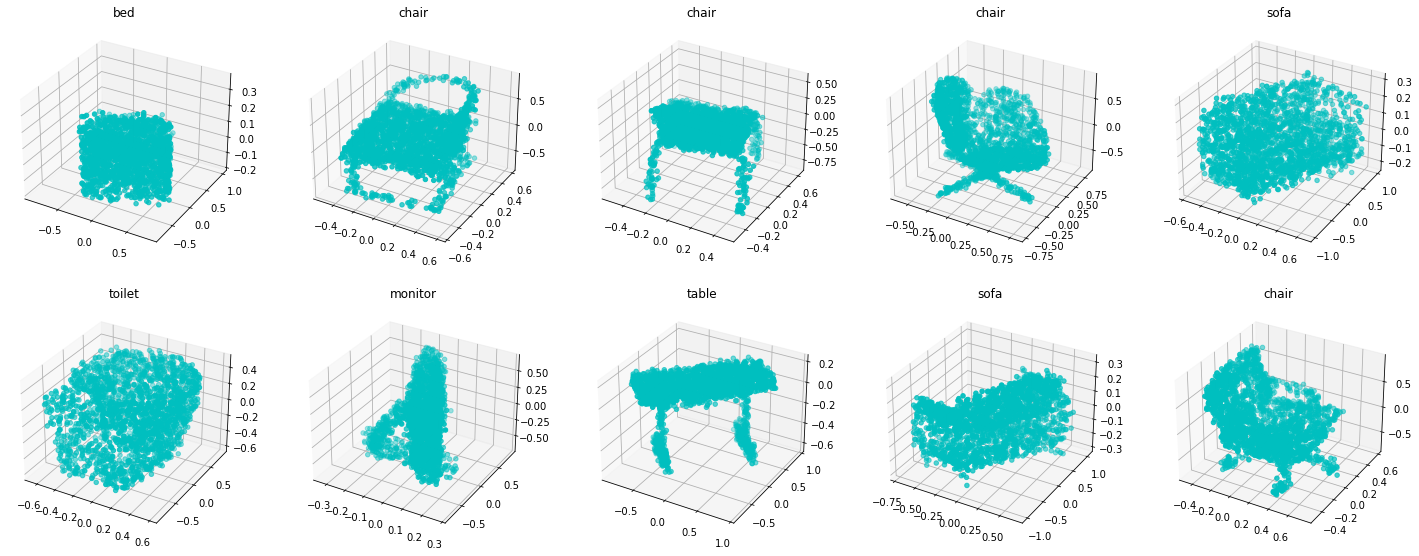

In [12]:
fig = plt.figure(figsize=(25, 25))
for i in range(10):
    ax = fig.add_subplot(5,5,i+1, projection='3d')
    s = data['pointcloud'][i]
    # plot a 3D surface like in the example mplot3d/surface3d_demo
    surf = ax.scatter(s[0,:].numpy(), s[1,:].numpy(), s[2, :].numpy(),color='c')
    plt.title(class_names[data['category'][i].item()])

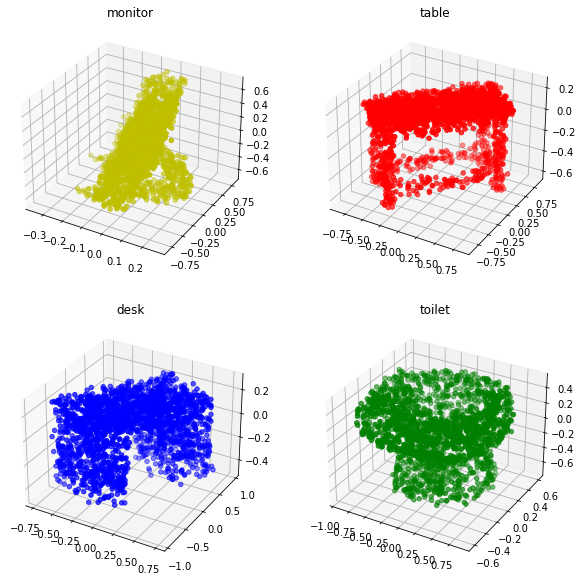

In [31]:
a = set3D[1].transpose(0,1).numpy()
b = set3D[2].transpose(0,1).numpy()
c = set3D[3].transpose(0,1).numpy()
d = set3D[4].transpose(0,1).numpy()
# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=(10, 10))
# =============
# First subplot
# =============
# set up the axes for the first plot
ax = fig.add_subplot(2, 2, 1, projection='3d')

# plot a 3D surface like in the example mplot3d/surface3d_demo
surf = ax.scatter(a[0,:], a[1,:], a[2, :],color='y')
plt.title(inv_classes[label3D[1].item()])
# ==============
# Second subplot
# ==============
# set up the axes for the second plot
ax = fig.add_subplot(2, 2, 2, projection='3d')

# plot a 3D surface like in the example mplot3d/surface3d_demo
surf = ax.scatter(b[0,:], b[1,:], b[2, :],color='r')
plt.title(inv_classes[label3D[2].item()])
# ==============
# ==============
# Third subplot
# ==============
# set up the axes for the second plot
ax = fig.add_subplot(2, 2, 3, projection='3d')

# plot a 3D surface like in the example mplot3d/surface3d_demo
surf = ax.scatter(c[0,:], c[1,:], c[2, :],color='b')
plt.title(inv_classes[label3D[3].item()])
# ==============
# ==============
# forth subplot
# ==============
# set up the axes for the second plot
ax = fig.add_subplot(2, 2, 4, projection='3d')

# plot a 3D surface like in the example mplot3d/surface3d_demo
surf = ax.scatter(d[0,:], d[1,:], d[2, :],color='g')
plt.title(inv_classes[label3D[4].item()])
# ==============
plt.show()


In [32]:
from utils import chamfer_loss
from utils import hungarian_loss
from fspool import FSPool
from model import FSEncoder
from dspn import *
from model import FSEncoderClasification
from MnistSet import MNISTSet
from MnistSet import get_loader

In [67]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torchvision
import matplotlib.pyplot as plt
import numpy as np



def build_net():
    set_channels = 3
    set_size = 2048
    hidden_dim = 256
    inner_lr = 800
    iters = 10
    latent_dim = 64
    input_encoder = None

    set_encoder = FSEncoder(set_channels, latent_dim, hidden_dim)
    set_decoder = DSPN(set_encoder, set_channels, set_size, hidden_dim, iters, inner_lr)
    net = Net(
        input_encoder=input_encoder, set_encoder=set_encoder, set_decoder=set_decoder
    )
    return net


class Net(nn.Module):
    def __init__(self, set_encoder, set_decoder, input_encoder=None):
        """
        In the auto-encoder setting, don't pass an input_encoder because the target set and mask is
        assumed to be the input.
        In the general prediction setting, must pass all three.
        """
        super().__init__()
        self.set_encoder = set_encoder
        self.input_encoder = input_encoder
        self.set_decoder = set_decoder

        for m in self.modules():
            if (
                isinstance(m, nn.Linear)
                or isinstance(m, nn.Conv2d)
                or isinstance(m, nn.Conv1d)
            ):
                init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, input, target_set, target_mask):
        if self.input_encoder is None:
            # auto-encoder, ignore input and use target set and mask as input instead
            latent_repr = self.set_encoder(target_set, target_mask)
            target_repr = latent_repr
        else:
            # set prediction, use proper input_encoder
            latent_repr = self.input_encoder(input)
            # note that target repr is only used for loss computation in training
            # during inference, knowledge about the target is not needed
            target_repr = self.set_encoder(target_set, target_mask)

        predicted_set = self.set_decoder(latent_repr)

        return predicted_set, (target_repr, latent_repr)

In [68]:
net = build_net()
net

Net(
  (set_encoder): FSEncoder(
    (conv): Sequential(
      (0): Conv1d(4, 256, kernel_size=(1,), stride=(1,))
      (1): ReLU()
      (2): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
      (3): ReLU()
      (4): Conv1d(256, 64, kernel_size=(1,), stride=(1,))
    )
    (pool): FSPool()
  )
  (set_decoder): DSPN(
    (encoder): FSEncoder(
      (conv): Sequential(
        (0): Conv1d(4, 256, kernel_size=(1,), stride=(1,))
        (1): ReLU()
        (2): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
        (3): ReLU()
        (4): Conv1d(256, 64, kernel_size=(1,), stride=(1,))
      )
      (pool): FSPool()
    )
  )
)

In [69]:
optimizer = torch.optim.Adam(
    [p for p in net.parameters() if p.requires_grad], lr=0.01
)

In [87]:
sample = set3D[2].clone().transpose(0,1).unsqueeze(0)
sample = sample.type(torch.float32)
sample.shape
sample.dtype

torch.float32

In [88]:
mask = torch.ones(1,2048,dtype=torch.float32)
mask.shape
mask.dtype

torch.float32

In [108]:
l = label3D[2].unsqueeze(0)
l

tensor([8])

In [94]:
for i in range(100):
    input, target_set, target_mask = l,sample,mask
    if(i == 1):
        print(input)
    (progress, masks, evals, gradn), (y_enc, y_label) = net(input, target_set, target_mask)
    #plt.grid(False)
    #plt.tight_layout()
    #print(len(progress))
  # if using mask as feature, concat mask feature into progress
    progress_only = progress
    target_set = torch.cat(
      [target_set, target_mask.unsqueeze(dim=1)], dim=1)
    progress = [
      torch.cat([p, m.unsqueeze(dim=1)], dim=1)
      for p, m in zip(progress, masks)
            ]
  # dim 0 is over the inner iteration steps
  # target set is broadcasted over dim 0
    set_loss = chamfer_loss(
      torch.stack(progress), target_set.unsqueeze(0)
    )
    loss = set_loss.mean()
    #print(set_loss)
    print(loss)
    progress = progress_only

    #print("New progress",len(progress))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

tensor(0.0011, grad_fn=<MeanBackward0>)
torch.Size([1])
tensor(0.0011, grad_fn=<MeanBackward0>)
tensor(0.0010, grad_fn=<MeanBackward0>)
tensor(0.0009, grad_fn=<MeanBackward0>)
tensor(0.0009, grad_fn=<MeanBackward0>)
tensor(0.0009, grad_fn=<MeanBackward0>)
tensor(0.0008, grad_fn=<MeanBackward0>)
tensor(0.0008, grad_fn=<MeanBackward0>)
tensor(0.0008, grad_fn=<MeanBackward0>)
tensor(0.0008, grad_fn=<MeanBackward0>)
tensor(0.0007, grad_fn=<MeanBackward0>)
tensor(0.0007, grad_fn=<MeanBackward0>)
tensor(0.0007, grad_fn=<MeanBackward0>)
tensor(0.0007, grad_fn=<MeanBackward0>)
tensor(0.0007, grad_fn=<MeanBackward0>)
tensor(0.0007, grad_fn=<MeanBackward0>)
tensor(0.0007, grad_fn=<MeanBackward0>)
tensor(0.0006, grad_fn=<MeanBackward0>)
tensor(0.0006, grad_fn=<MeanBackward0>)
tensor(0.0006, grad_fn=<MeanBackward0>)
tensor(0.0006, grad_fn=<MeanBackward0>)
tensor(0.0006, grad_fn=<MeanBackward0>)
tensor(0.0006, grad_fn=<MeanBackward0>)
tensor(0.0006, grad_fn=<MeanBackward0>)
tensor(0.0005, grad_fn=<

In [97]:
input, target_set, target_mask = l,sample,mask
(progress, masks, evals, gradn), (y_enc, y_label) = net(input, target_set, target_mask)
resultado = progress[10].detach().squeeze(0).numpy()
resultado.shape

(3, 2048)

In [99]:
pcshow(*sample.squeeze(0))

In [98]:
pcshow(*resultado)

Text(0.5, 0.92, 'Target table')

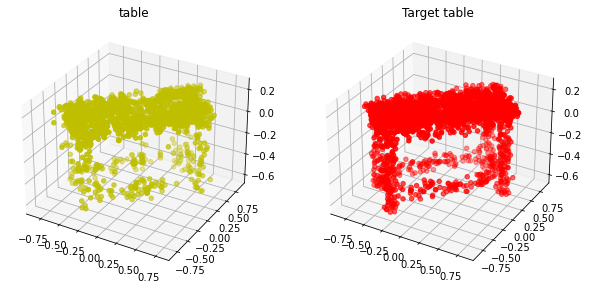

In [111]:
# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=(10, 10))
# =============
# First subplot
# =============
# set up the axes for the first plot
ax = fig.add_subplot(1, 2, 1, projection='3d')
# plot a 3D surface like in the example mplot3d/surface3d_demo
surf = ax.scatter(resultado[0,:], resultado[1,:], resultado[2, :],color='y')
plt.title(inv_classes[label3D[2].item()])
# ==============
# Second subplot
# ==============
# set up the axes for the second plot
ax = fig.add_subplot(1, 2, 2, projection='3d')
b = sample.squeeze(0).numpy()
# plot a 3D surface like in the example mplot3d/surface3d_demo
surf = ax.scatter(b[0,:], b[1,:], b[2, :],color='r')
plt.title("Target " + inv_classes[label3D[2].item()])